# Air pollution GRU and LSTM model

In [1]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import lightning as L
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
import seaborn as sn
import matplotlib.pyplot as plt

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

## Exploring the dataset

In [17]:
pollution_df  = pd.read_csv("data/LSTM-Multivariate_pollution.csv")

In [22]:
pollution_df.head()

,date,pollution,dew,temp,press,wnd_dir,wnd_spd,snow,rain
0,2010-01-02 00:00:00,129.0,-16,-4.0,1020.0,SE,1.79,0,0
1,2010-01-02 01:00:00,148.0,-15,-4.0,1020.0,SE,2.68,0,0
2,2010-01-02 02:00:00,159.0,-11,-5.0,1021.0,SE,3.57,0,0
3,2010-01-02 03:00:00,181.0,-7,-5.0,1022.0,SE,5.36,1,0
4,2010-01-02 04:00:00,138.0,-7,-5.0,1022.0,SE,6.25,2,0


In [23]:
pollution_df.shape

(43800, 9)

In [24]:
pollution_df.dtypes

date          object
pollution    float64
dew            int64
temp         float64
press        float64
wnd_dir       object
wnd_spd      float64
snow           int64
rain           int64
dtype: object

In [25]:
pollution_df.describe()

,pollution,dew,temp,press,wnd_spd,snow,rain
count,43800.000000,43800.000000,43800.000000,43800.000000,43800.000000,43800.000000,43800.000000
mean,94.013516,1.828516,12.459041,1016.447306,23.894307,0.052763,0.195023
std,92.252276,14.429326,12.193384,10.271411,50.022729,0.760582,1.416247
min,0.000000,-40.000000,-19.000000,991.000000,0.450000,0.000000,0.000000
25%,24.000000,-10.000000,2.000000,1008.000000,1.790000,0.000000,0.000000
50%,68.000000,2.000000,14.000000,1016.000000,5.370000,0.000000,0.000000
75%,132.250000,15.000000,23.000000,1025.000000,21.910000,0.000000,0.000000
max,994.000000,28.000000,42.000000,1046.000000,585.600000,27.000000,36.000000


In [26]:
pollution_df.wnd_dir.unique()

array(['SE', 'cv', 'NW', 'NE'], dtype=object)

In [27]:
pollution_df.isna().sum()

date         0
pollution    0
dew          0
temp         0
press        0
wnd_dir      0
wnd_spd      0
snow         0
rain         0
dtype: int64

## Visualization

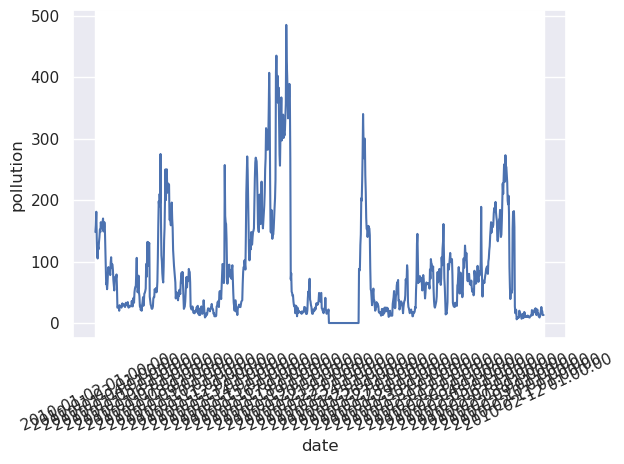

In [28]:
sn.set_theme(style="darkgrid")

plot_ = sn.lineplot(x="date"
                    , y="pollution"
                    , data=pollution_df.iloc[1:1000,:])

for ind, label in enumerate(plot_.get_xticklabels()):
    if ind % 24 == 0:
        label.set_visible(True)
    else:
        label.set_visible(False)

plt.xticks(rotation = 25)
plt.tight_layout()
plt.show()

## Pytorch codes

### Custom dataset class

In [72]:
# Custom dataset class for pollution data
class PollutionData(Dataset):
    def __init__(self, X, y, seq_len, device=device):
        # Features and targets
        self.X = X
        self.y = y
        # Length of sequence
        self.seq_len = seq_len
        # Chosen device
        self.device = device

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        # Concatenate X and y to use target lags as input
        X_sample = np.concatenate([self.X, self.y], axis=1)
        
        # If the index is lower than sequence length, then apply padding
        if idx >= self.seq_len:
            X_sample = X_sample[(idx - self.seq_len):idx]      
        else:
            X_sample = X_sample[:idx]
            padding = np.zeros((self.seq_len - idx, X_sample.shape[1]))
            X_sample = np.concatenate([padding, X_sample], axis = 0)
        
        return torch.tensor(X_sample).to(torch.float32).to(self.device), torch.tensor(self.y[idx]).to(torch.float32).to(self.device)

### Lightning dataloader

In [73]:
# Custom lightning dataloader
class PollutionDataLoader(L.LightningDataModule):
    def __init__(self, train_dir, test_dir, seq_len, X_scaler, y_scaler, test_size, random_state, batch_size, num_workers, device):
        super().__init__()
        self.train_dir = train_dir
        self.test_dir = test_dir
        self.seq_len = seq_len
        self.X_scaler = X_scaler
        self.y_scaler = y_scaler
        self.test_size = test_size
        self.random_sate = random_state
        self.batch_size = batch_size
        self.num_workers = num_workers
        self.device = device
        self.train_df = None
        self.test_df = None
        self.X_train = None
        self.y_train = None
        self.X_val = None
        self.y_val = None
        self.X_test = None
        self.y_test = None
        self.pollution_train = None
        self.pollution_val = None

    def setup(self, stage):
        # Load the training dataset
        self.train_df = pd.read_csv(self.train_dir)
        # Map the categories of wind direction to numeric values
        mapping = {"NE": 0, "NW": 1, "SE": 2, "cv": 3}
        self.train_df["wnd_dir"] = self.train_df.wnd_dir.map(mapping)
        # Create X and y by dropping date and seperating features and target
        X = self.train_df.drop(["date", "pollution"], axis=1)
        y = self.train_df[["pollution"]]
        # Apply train test split
        self.X_train, self.X_val, self.y_train, self.y_val = train_test_split(X
                                                                              , y
                                                                              , test_size=self.test_size
                                                                              , shuffle=False
                                                                              , random_state=self.random_sate
                                                                              )
        
        # Transform with scaler if provided
        if self.X_scaler and self.y_scaler:
            self.X_train = self.X_scaler.fit_transform(self.X_train)
            self.X_val = self.X_scaler.transform(self.X_val)
            self.y_train = self.y_scaler.fit_transform(self.y_train)
            self.y_val = self.y_scaler.transform(self.y_val)

        # Create two instances of the custom dataset class
        self.pollution_train = PollutionData(self.X_train
                                             , self.y_train
                                             , seq_len=self.seq_len
                                             , device=self.device
                                             )
        self.pollution_val = PollutionData(self.X_val
                                             , self.y_val
                                             , seq_len=self.seq_len
                                             , device=self.device
                                             )

    def train_dataloader(self):
        # Return the dataloader of train data
        return DataLoader(self.pollution_train
                          , shuffle=True
                          , batch_size=self.batch_size
                          , drop_last=False
                          , num_workers=self.num_workers
                          )

    def val_dataloader(self):
        # Return the dataloader of validation data
        return DataLoader(self.pollution_val
                          , shuffle=False
                          , batch_size=self.batch_size
                          , drop_last=False
                          , num_workers=self.num_workers
                          )

### LSTM model class

In [4]:
# LSTM model class
class LSTMModel(nn.Module):
    def __init__(self, in_size, h_size, num_l, out_f):
        super().__init__()
        self.input_size = in_size
        self.hidden_size = h_size
        self.num_layers = num_l
        self.out_features = out_f
        self.lstm = nn.LSTM(input_size=self.input_size
                            , hidden_size=self.hidden_size
                            , num_layers=self.num_layers
                            , batch_first=True
                            , dropout=0.1
                            )
        self.linear1 = nn.Linear(in_features=self.hidden_size
                                 , out_features=self.out_features)
    
    def forward(self, X):
        X, _ = self.lstm(X)
        X = self.linear1(X[:,-1,:])

        return X

### GRU model class

In [5]:
# GRU model class
class GRUModel(nn.Module):
    def __init__(self, in_size, h_size, num_l, out_f):
        super().__init__()
        self.input_size = in_size
        self.hidden_size = h_size
        self.num_layers = num_l
        self.out_features = out_f
        self.lstm = nn.GRU(input_size=self.input_size
                           , hidden_size=self.hidden_size
                           , num_layers=self.num_layers
                           , batch_first=True
                           , dropout=0.1
                           )
        self.linear1 = nn.Linear(in_features=self.hidden_size
                                 , out_features=self.out_features
                                 )
    
    def forward(self, X):
        X, _ = self.lstm(X)
        X = self.linear1(X[:,-1,:])

        return X

### Lightning time-series model class

In [6]:
# Time-series model created with lightning
class TSModel(L.LightningModule):
    def __init__(self, model, lr=0.01):
        super().__init__()
        # Model of choice (either LSTM or GRU)
        self.model = model
        # Learning rate
        self.lr = lr

    def training_step(self, batch, batch_idx):
        X, y = batch
        y_pred = self.model(X)
        train_loss = F.mse_loss(y_pred, y)
        self.log("train_loss", train_loss, prog_bar=True, on_step=False, on_epoch=True)
        return train_loss
    
    def validation_step(self, batch, batch_idx):
        X, y = batch
        y_pred = self.model(X)
        val_loss = F.mse_loss(y_pred, y)
        self.log("val_loss", val_loss, prog_bar=True, on_step=False, on_epoch=True)

    def test_step(self, batch, batch_idx):
        X, y = batch
        y_pred = self.model(X)
        test_loss = F.mse_loss(y_pred, y)
        self.log("test_loss", test_loss)

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=self.lr)
        return optimizer

### Training loop

In [74]:
# Creating the lightning data loader
pollution_loader = PollutionDataLoader(train_dir="data/LSTM-Multivariate_pollution.csv"
                                       , test_dir=None
                                       , seq_len=10
                                       , X_scaler=MinMaxScaler()
                                       , y_scaler=MinMaxScaler()
                                       , test_size=0.3
                                       , random_state=42
                                       , batch_size=128
                                       , num_workers=7
                                       , device=device
                                       )

#### LSTM

In [75]:
lstm_model = LSTMModel(in_size = 8, h_size = 8, num_l = 4, out_f = 1).to(device)
lstm_ts_model = TSModel(lstm_model)

lstm_trainer = L.Trainer(max_epochs=2, enable_checkpointing=False)
lstm_trainer.fit(lstm_ts_model, datamodule=pollution_loader)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs



  | Name  | Type      | Params
------------------------------------
0 | model | LSTMModel | 2.3 K 
------------------------------------
2.3 K     Trainable params
0         Non-trainable params
2.3 K     Total params
0.009     Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=2` reached.


#### GRU

In [ ]:
gru_model = LSTMModel(in_size = 8, h_size = 8, num_l = 4, out_f = 1).to(device)
gru_ts_model = TSModel(lstm_model)

gru_trainer = L.Trainer(max_epochs=3, enable_checkpointing=False)
gru_trainer.fit(gru_ts_model, pollution_loader.train_dataloader, pollution_loader.val_dataloader)

#### Functions

In [17]:
# Plot the loss curve
def plot_loss_curve(train_loss_list, val_loss_list, n_epochs):
    x_range = range(1, n_epochs+1)

    plt.plot(x_range, train_loss_list)
    plt.plot(x_range, val_loss_list)
    plt.title("Loss curve")
    plt.xlabel("Epoch")
    plt.ylabel("Loss metric")
    plt.xticks(x_range)
    plt.show()


# Predicting on new data
def predict_model(model, data_loader):
    model.eval()
    output = torch.tensor([])

    with torch.no_grad():
        for X, _ in data_loader:
            y_pred = model(X)
            output = torch.cat((output, y_pred), 0)
    
    return output.cpu().numpy()